# <center> **Consumer Behavior and Shopping Habits Research**

---

# <center> *Let's begin!*

## Import libraries

In [83]:
import numpy as np
import pandas as pd

import functions as funcs

import matplotlib.pyplot as plt
import seaborn as sb 

from sklearn import preprocessing as pp
from sklearn import model_selection as ms 
from sklearn import linear_model as lm
from sklearn import tree as t 
from sklearn import ensemble as ens 
from sklearn import cluster as c 
from sklearn import metrics as m
from sklearn import pipeline as pl
from sklearn import mixture as mx 
from sklearn import multiclass as mc

import xgboost as xgb  

plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

import pickle

RS = 95
pallete = 'muted'

## Read Data

In [84]:
data = pd.read_csv('data/shopping_behavior_updated.csv')

data

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3896,40,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,2-Day Shipping,No,No,32,Venmo,Weekly
3896,3897,52,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,Store Pickup,No,No,41,Bank Transfer,Bi-Weekly
3897,3898,46,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Standard,No,No,24,Venmo,Quarterly
3898,3899,44,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,Express,No,No,24,Venmo,Weekly


## Basic Information

Let's see what our data is.

In [85]:
funcs.get_data_info(data) 

,Nulls,Uniques,Dtypes
Customer ID,0.0,3900,int64
Age,0.0,53,int64
Gender,0.0,2,object
Item Purchased,0.0,25,object
Category,0.0,4,object
Purchase Amount (USD),0.0,81,int64
Location,0.0,50,object
Size,0.0,4,object
Color,0.0,25,object
Season,0.0,4,object


> There are no Null values in our data

In [86]:
data.describe(exclude='object').round(2) 

,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.00,3900.00,3900.00,3900.00,3900.00
mean,1950.50,44.07,59.76,3.75,25.35
std,1125.98,15.21,23.69,0.72,14.45
min,1.00,18.00,20.00,2.50,1.00
25%,975.75,31.00,39.00,3.10,13.00
50%,1950.50,44.00,60.00,3.70,25.00
75%,2925.25,57.00,81.00,4.40,38.00
max,3900.00,70.00,100.00,5.00,50.00


In [87]:
data.describe(include='object').round(2) 

,Gender,Item Purchased,Category,Location,Size,Color,Season,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Payment Method,Frequency of Purchases
count,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900
unique,2,25,4,50,4,25,4,2,6,2,2,6,7
top,Male,Blouse,Clothing,Montana,M,Olive,Spring,No,Free Shipping,No,No,PayPal,Every 3 Months
freq,2652,171,1737,96,1755,177,999,2847,675,2223,2223,677,584


We can delete `Customer ID` and `Discount Applied` columns. First one has the same number of unique values and it's values in general. The last one is logically idetntical to `Promo Code Used`, beacause if promo code was used, then discount was applied.

In [88]:
data.drop(['Customer ID', 'Discount Applied'], axis=1, inplace=True)

data

,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,14,Venmo,Fortnightly
1,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,2,Cash,Fortnightly
2,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,23,Credit Card,Weekly
3,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,49,PayPal,Weekly
4,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,31,PayPal,Annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,40,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,2-Day Shipping,No,32,Venmo,Weekly
3896,52,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,Store Pickup,No,41,Bank Transfer,Bi-Weekly
3897,46,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Standard,No,24,Venmo,Quarterly
3898,44,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,Express,No,24,Venmo,Weekly


----

# <center> *Here comes the EDA*

I selected 3 different target variables, so I will research this data in the context of them, because in my opinion these features describe consumers' behavior directly. Also each variable has it's own method of analysis (after "-"):

1. `Purchase Amount (USD)` - correlation with other variables

2. `Subscription Status` - bayesian probability of a class

3. `Frequency of Purchases` - 

Let's divide our data by types of variables: 
- **Numeric** (`int`, `float`)
- **Categorical** (`object`, `int`)

In [89]:
num_cols = []

print('Numeric data:')
for col in data.columns:
    if data[col].dtype != 'object':
        num_cols.append(col)
        print('\t'+col)


cat_cols = []

print('\nCategorical data:')
for col in data.columns:
    if data[col].dtype == 'object':
        cat_cols.append(col)
        print('\t'+col)

Numeric data:
	Age
	Purchase Amount (USD)
	Review Rating
	Previous Purchases

Categorical data:
	Gender
	Item Purchased
	Category
	Location
	Size
	Color
	Season
	Subscription Status
	Shipping Type
	Promo Code Used
	Payment Method
	Frequency of Purchases


---

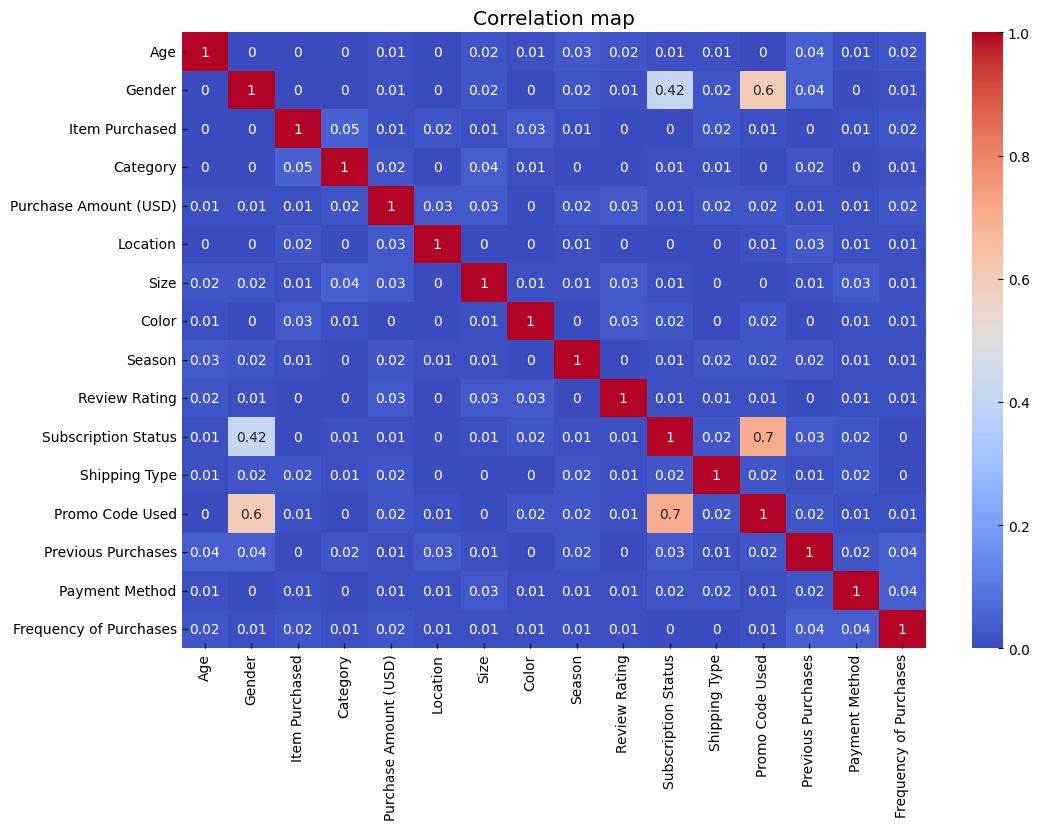

In [97]:
def get_cats(data):
    df = data.copy()

    for x in data.columns:
        if df[x].dtype == 'object':
            df[x] = (df[x]
                     .astype('category')
                     .cat
                     .codes)
            
    return df

corr_data = (get_cats(data)
             .corr()
             .abs()
             .round(2))

plt.figure(figsize=(12, 8))
sb.heatmap(corr_data, 
           annot=True, 
           cmap='coolwarm')

plt.title('Correlation map')
plt.show()

## *Purchase Amount*

In [95]:



def show_corr_bars(target, data=data):
    x = (get_cats(data)
         .corr()
         .abs()
         .loc[target]
         .drop(target))
    
    plt.figure(figsize=(20, 7))
    sb.barplot(x, palette=pallete)
    
    plt.xticks(rotation=45)
    plt.title(f'Correleation of {target} with selected features')
    plt.show()

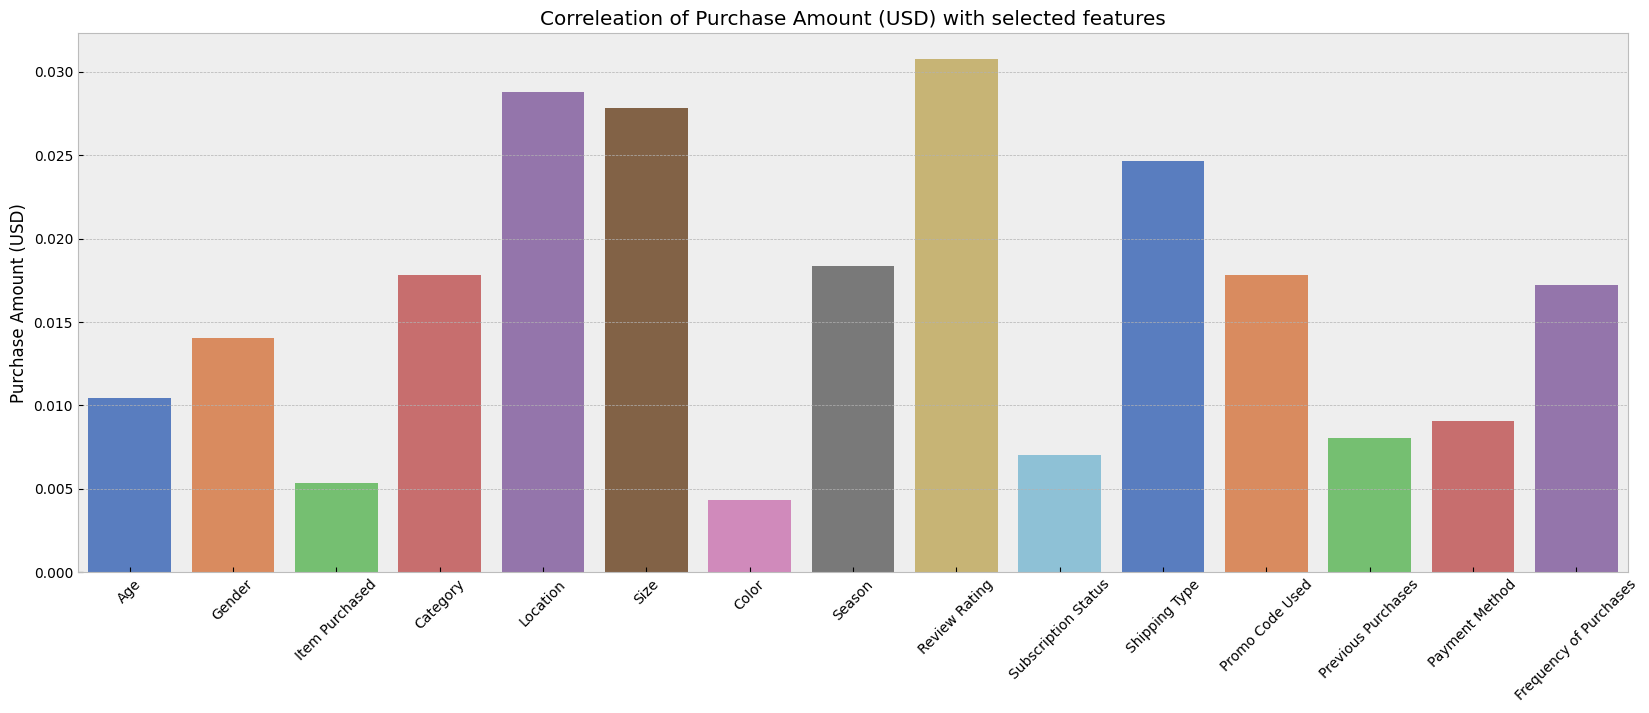

In [96]:
show_corr_bars('Purchase Amount (USD)') 

## *Frequency of Purchases*

In [ ]:
def show_mean_freq(feat, data=data):
    mean_data = (data
                 .groupby('Frequency of Purchases')[feat]
                 .mean())
    
    if data[feat].dtype == float:
        m_val = int(mean_data.mean()) + 0.5
    else:
        m_val = int(mean_data.mean() / 10) * 10
    
    mean_data -= m_val
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    sb.kdeplot(data, 
               x=feat, 
               hue='Frequency of Purchases', 
               bw_adjust=0.4,
               ax=ax[0])
    
    sb.barplot(mean_data, palette='muted', ax=ax[1])
    
    ax[0].set_title(f'Normalised distribution of {feat}')
    
    ax[1].set_title(f'Mean {feat} per Frequency of Purchases')
    ax[1].set_ylabel(f'{feat} (+ {m_val})')
    fig.show()
    

for col in data.columns:
    if data[col].dtype != 'object':
        print(col)

### *Age*

In [ ]:
show_mean_freq('Age') 

### *Purchase Amount (USD)*

In [ ]:
show_mean_freq('Purchase Amount (USD)')

### *Review Rating*

In [ ]:
show_mean_freq('Review Rating')

### *Previous Purchases*

In [ ]:
show_mean_freq('Previous Purchases')

> Distribution in all numeric features is **uniform**. 

---

## Categorical data

In [ ]:
show_corr_bars('Subscription Status')

In [ ]:
def get_bayesian_proba(A, 
                       B, 
                       calc_proba, 
                       given_that, 
                       data=data):
    
    ct_data = pd.crosstab(index=data[A], 
                          columns=data[B], 
                          margins=True)
    
    # Conditional probability:
    # p(B|A) = p(B and A) / p(A)
    proba_BA = (ct_data.loc[calc_proba, given_that] 
                / ct_data.loc[calc_proba, 'All'])
    
    # Bayesian probability:
    # p(A|B) = p(A) * p(B|A) / p(B)
    proba_AB = (ct_data.loc[calc_proba, 'All'] 
                * proba_BA 
                / ct_data.loc['All', given_that])
    
    return round(proba_AB, 2)


def show_bayes_bars(X, 
                    y='Frequency of Purchases', 
                    data=data):
    X_vals = data[X].unique()
    y_vals = data[y].unique()
    
    X_list = []
    y_list = []
    probas = []

    for typ in y_vals:
        for val in X_vals:
            X_list.append(val)
            y_list.append(typ)
            
            p = get_bayesian_proba(A=X, 
                                   B=y, 
                                   calc_proba=val, 
                                   given_that=typ)
            probas.append(p)
            
    bayes_data = pd.DataFrame({X: X_list, 
                               y: y_list, 
                               'Probability': probas})
    
    plt.figure(figsize=(len(y_vals)*2, 5))
    sb.barplot(bayes_data, 
               x=y, 
               y='Probability', 
               hue=X)
    
    plt.title(f'Probability of {X} when {y} is given')
    plt.show()
    

for col in data.columns:
    if data[col].nunique() <= 10:
        print(col)

Gender
Category
Size
Season
Subscription Status
Shipping Type
Promo Code Used
Payment Method
Frequency of Purchases


### *Gender*

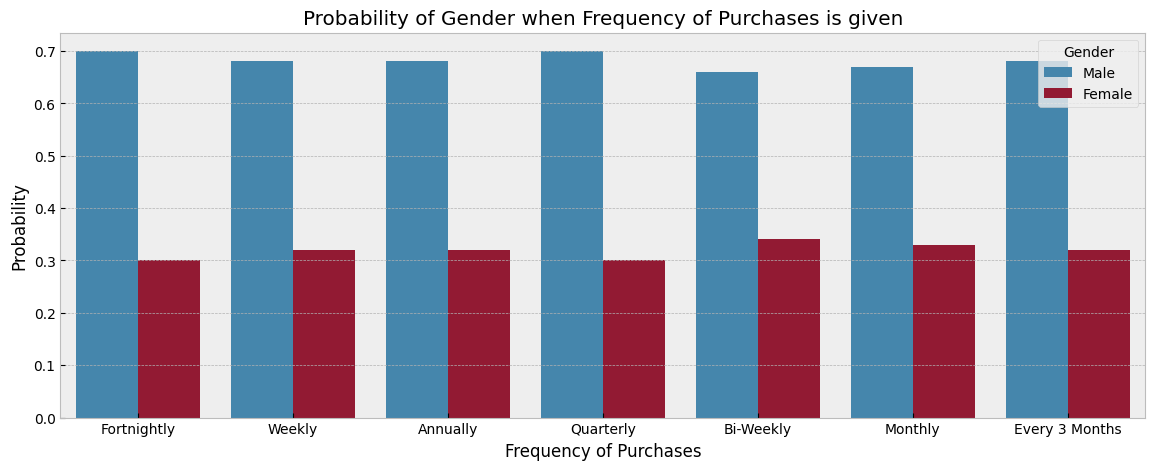

In [ ]:
show_bayes_bars('Gender') 

### *Category*

In [ ]:
show_bayes_bars('Category')

### *Size*

In [ ]:
show_bayes_bars('Size')

### *Season*

In [ ]:
show_bayes_bars('Season')

### *Subscription Status*

In [ ]:
show_bayes_bars('Subscription Status') 

### *Shipping Type*

In [ ]:
show_bayes_bars('Shipping Type') 

### *Promo Code Used*

In [ ]:
show_bayes_bars('Promo Code Used')

### *Payment Method*

In [ ]:
show_bayes_bars('Payment Method')

---

## Other type data

In [ ]:
for col in data.columns:
    if ((data[col].nunique() > 10) and 
        (data[col].dtype == 'object')):
        
        print(col) 

### *Item Purchased*

In [ ]:
data['Item Purchased'].value_counts()

In [ ]:
items_vc = data['Item Purchased'].value_counts()

plt.figure(figsize=(15, 5))
sb.barplot(items_vc, palette='muted')

plt.xticks(rotation='vertical')
plt.show()

### *Location*

In [ ]:
data['Location'].value_counts().index

In [ ]:
def change_location(x):
    zones = {'0': ['New Jersey', 'Connecticut', 'Rhode Island', 'Massachusetts', 'New Hampshire', 'Vermont', 'Maine'], 
             '1': ['Delaware', 'Pennsylvania', 'New York'], 
             '2': ['Maryland', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina'], 
             '3': ['Mississippi', 'Tennessee', 'Alabama', 'Georgia', 'Florida'], 
             '4': ['Michigan', 'Indiana', 'Ohio', 'Kentucky'], 
             '5': ['Montana', 'North Dakota', 'South Dakota', 'Minnesota', 'Iowa', 'Wisconsin'], 
             '6': ['Nebraska', 'Kansas', 'Missouri', 'Illinois'], 
             '7': ['Texas', 'Oklahoma', 'Arkansas', 'Louisiana'], 
             '8': ['Idaho', 'Wyoming', 'Utah', 'Nevada', 'Colorado', 'Arizona', 'New Mexico'], 
             '9': ['Washington', 'Oregon', 'California', 'Alaska', 'Hawaii']}
    
    for k, v in zones.items():
        if x in v:
            x = k
    
    return x


locs_vc = (data['Location']
           .apply(change_location)
           .value_counts())

plt.figure(figsize=(15, 5))
sb.barplot(locs_vc, palette='muted')

plt.show()

### *Color*

In [ ]:
data['Color'].value_counts()

In [ ]:
def change_color(x):
    colors = {'Red': ['Maroon'], 
              'Yellow': ['Gold'], 
              'Green': ['Olive'], 
              'Blue': ['Teal', 'Cyan', 'Indigo', 'Turquoise'],
              'Purple': ['Violet', 'Lavender'], 
              'Pink': ['Magenta', 'Peach'], 
              'Gray': ['Silver', 'Charcoal', 'Beige']}
    
    for k, v in colors.items():
        if x in v:
            x = k
    
    return x


colors_vc = (data['Color']
             .apply(change_color)
             .value_counts())

c_palette = (colors_vc
             .index
             .tolist())

plt.figure(figsize=(15, 5))
sb.barplot(colors_vc, palette=c_palette)

plt.show()

---

# <center> *Data Processing & Modeling*

In [ ]:
def X_y_split(target, data=data): 
    X = data.drop(target, axis=1)
    y = data[target]
    
    return X, y 


def trains_tests_split(X, y):    
    X_train, X_test, y_train, y_test = \
        ms.train_test_split(X, y, 
                            random_state=RS, 
                            test_size=0.2)
    
    print(f'Train sample counts {X_train.shape[0]} rows')
    print(f'Test sample counts {X_test.shape[0]} rows')
    
    return X_train, X_test, y_train, y_test


def transform_X(X, transformer):
    X_ = transformer.fit_transform(X)
    
    return pd.DataFrame(X_, columns=X.columns)


def dump_model(model, task_dir, f_name):
    with open(f'models/{task_dir}/{f_name}.pkl', 'wb') as m_file:
        pickle.dump(model, m_file)
        
    print(f'{model}\nis saved into "{task_dir}".')
    
    
reg_dir = 'purchase_amount'
clf_dir = 'subscription_status'
mcc_dir = 'frequency_of_purchases'

---

## Regression task

In [ ]:
X, y = X_y_split('Purchase Amount (USD)')

X.head()

### *Encoding*

In [ ]:
encoder = pp.OrdinalEncoder()
X = transform_X(X, encoder)

X.head()

In [ ]:
dump_model(encoder, reg_dir, 'reg_encoder') 

### *Scaling*

In [ ]:
scaler = pp.MinMaxScaler()
X = transform_X(X, scaler)

X.head()

In [ ]:
dump_model(scaler, reg_dir, 'reg_scaler')

### *Linear Regression (baseline)*

In [ ]:
X_train, X_test, y_train, y_test = trains_tests_split(X, y) 

In [ ]:
def print_scores(train, test):
    print(f'Train score: {train.round(2)}')
    print(f'Test score: {test.round(2)}\n')
    print(f'Difference is {np.abs(train-test).round(2)}')


def get_model_scores(model, 
                     scoring, 
                     X_train=X_train, 
                     X_test=X_test, 
                     y_train=y_train, 
                     y_test=y_test):
    
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_score = scoring(y_train, y_pred_train)
    test_score = scoring(y_test, y_pred_test)
    
    print_scores(train_score, test_score)
    
    
get_regression_scores = lambda model: get_model_scores(model, m.mean_absolute_percentage_error)

In [ ]:
def gridsearch_opt(model, params, scoring):
    search = ms.RandomizedSearchCV(model, 
                                   params, 
                                   scoring=scoring, 
                                   cv=10, 
                                   random_state=RS,
                                   n_jobs=-1)
    
    search.fit(X_train, y_train)
    
    train_score = search.score(X_train, y_train)
    test_score = search.score(X_test, y_test)

    print_scores(train_score, test_score)
    
    return search.best_params_
    

gs_opt_regression = lambda model, params: gridsearch_opt(model, 
                                                         params=params, 
                                                         scoring='neg_mean_absolute_percentage_error')

In [ ]:
base_reg = lm.LinearRegression(n_jobs=-1)

get_regression_scores(base_reg)

In [ ]:
pf = pp.PolynomialFeatures(degree=2)

X_train_poly = pf.fit_transform(X_train, y_train)
X_test_poly = pf.fit_transform(X_test, y_train)

feats_diff = X_train_poly.shape[1] - X_train.shape[1]
print(f'Number of polynomial features is {feats_diff}.\n')

get_model_scores(lm.LinearRegression(n_jobs=-1), 
                 m.mean_absolute_percentage_error, 
                 X_train=X_train_poly, 
                 X_test=X_test_poly)

### *Stochastic Gradient Descend*

In [ ]:
sgd_reg = lm.SGDRegressor(random_state=RS)

get_regression_scores(sgd_reg)

In [ ]:
sgd_params = {
    
}

### *Decision Tree*

In [ ]:
dt_reg = t.DecisionTreeRegressor(random_state=RS)

get_regression_scores(dt_reg)

In [ ]:
dt_params = {'max_depth': [3, 4, 5, 6], 
             'min_samples_leaf': [1, 2, 3, 4]}

gs_opt_regression(dt_reg, dt_params)

### *Random Forest*

In [ ]:
rf_reg = ens.RandomForestRegressor(random_state=RS, n_jobs=-1)

get_regression_scores(rf_reg)

In [ ]:
rf_params = {'n_estimators': [100, 200, 300], 
             'max_depth': [3, 4, 5]}

gs_opt_regression(rf_reg, rf_params)

### *Subtotal (regression)*

I think, there is no point to use more complex models, because they don't show greater efficienсy, and MAPE score is already pretty good even on the baseline.

In [ ]:
show_coefs = lambda model, X=X: pd.DataFrame(model.coef_.reshape((1, 15)), 
                                             index=['w'], 
                                             columns=X.columns) 
    

show_coefs(base_reg)

In [ ]:
dump_model(base_reg, reg_dir, 'reg_model') 

---

## Classification task

In [ ]:
X, y = X_y_split('Subscription Status')

X.head()

### *Encoding*

In [ ]:
encoder = pp.OrdinalEncoder()
X = transform_X(X, encoder)

X.head()

In [ ]:
y = y.apply(lambda x: 1 if x == 'Yes' else 0)

y

In [ ]:
dump_model(encoder, clf_dir, 'clf_encoder')

### *Scaling*

In [ ]:
scaler = pp.MinMaxScaler()
X = transform_X(X, scaler)

X.head()

In [ ]:
dump_model(scaler, clf_dir, 'clf_scaler')

### *Logistic Regression (baseline)*

In [ ]:
X_train, X_test, y_train, y_test = trains_tests_split(X, y) 

In [ ]:
get_classification_score = lambda model: get_model_scores(model, 
                                                          m.accuracy_score, 
                                                          X_train=X_train, 
                                                          X_test=X_test, 
                                                          y_train=y_train, 
                                                          y_test=y_test)

gs_opt_classification = lambda model, params: gridsearch_opt(model, 
                                                             params=params, 
                                                             scoring='accuracy')

In [ ]:
base_clf = lm.LogisticRegression(random_state=RS, n_jobs=-1)

get_classification_score(base_clf)

### *Stochastic Gradient Descend*

In [ ]:
sgd_clf = lm.SGDClassifier(random_state=RS, n_jobs=-1)

get_classification_score(sgd_clf)

In [ ]:
sgd_params = {'loss': ['hinge', 'log_loss', 'perceptron', 'huber'], 
              'alpha': np.linspace(1e-6, 10, 20), 
              'tol': np.linspace(1e-6, 10, 20)}

gs_opt_classification(sgd_clf, sgd_params)

### *Decision Tree*

In [ ]:
dt_clf = t.DecisionTreeClassifier(random_state=RS)

get_classification_score(dt_clf)

In [ ]:
dt_params = {'criterion': ['gini', 'entropy', 'log_loss'],
             'max_depth': [3, 4, 5, 6], 
             'min_samples_leaf': [1, 2, 3, 4]}

gs_opt_classification(dt_clf, dt_params)

### *Random Forest*

In [ ]:
rf_clf = ens.RandomForestClassifier(random_state=RS, n_jobs=-1)

get_classification_score(rf_clf)

In [ ]:
rf_params = {'criterion': ['gini', 'entropy', 'log_loss'],
             'n_estimators': [100, 200, 300], 
             'max_depth': [3, 4, 5]}

gs_opt_classification(rf_clf, rf_params)

### *Gradient Boosting*

In [ ]:
gb_clf = ens.GradientBoostingClassifier(random_state=RS)

get_classification_score(gb_clf)

In [ ]:
gb_params = {'loss': ['log_loss', 'deviance', 'exponential'], 
             'max_depth': [3, 5, 7], 
             'learning_rate': [0.001, 0.1, 1, 3]}

gs_opt_classification(gb_clf, gb_params)

### *XGBoost*

In [ ]:
xgb_clf = xgb.XGBClassifier(seed=RS, use_label_encoder=False)

get_classification_score(xgb_clf)

In [ ]:
xgbc_params = {'learning_rate': [0.05, 0.1, 0.3], 
               'max_depth': [3, 5, 7, 9], 
               'min_child_weight': [3, 5, 7, 9], 
               'max_delta_step': [3, 5, 7], 
               'sampling_method': ['uniform', 'gradient_based']}

gs_opt_classification(xgb_clf, xgbc_params)

### *Subtotal (classification)*

Once again, more complex models do not lead to greater efficiency. So I will save basic model.

In [ ]:
show_coefs(base_clf, X=X)

In [ ]:
dump_model(base_clf, clf_dir, 'clf_model')

---

## Clustering task & Multiclass classification 

In [ ]:
X, y = X_y_split('Frequency of Purchases')

X.head()

### *Encoding*

In [ ]:
encoder = pp.OrdinalEncoder()
X = transform_X(X, encoder)

X.head()

In [ ]:
dump_model(encoder, mcc_dir, 'mcc_encoder') 

In [ ]:
lab_enc = pp.LabelEncoder()
y = lab_enc.fit_transform(y)

y

In [ ]:
dump_model(lab_enc, mcc_dir, 'y_encoder') 

### *Scaling*

In [ ]:
scaler = pp.MinMaxScaler()
X = transform_X(X, scaler)

X.head()

In [ ]:
dump_model(scaler, mcc_dir, 'mcc_scaler')

---

### <center> **MY IDEA**

The fact is that standard `sklearn.metrics` methods are not so efficient. For example, if we use `accuracy` with `OneVsRestClassifier`, it shows **too low** score on train and test samples both. 

In [ ]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, 
                                                       random_state=RS, 
                                                       test_size=0.2, 
                                                       stratify=y) 

In [ ]:
ovr_mcc = mc.OneVsRestClassifier(base_clf, n_jobs=-1)

get_classification_score(ovr_mcc)

So I decided to create my own metric of multiclass classification: **MATCH RATE** - `match_rate_score`. 

The idea is very simple: 
* We make prediction and calculate diffrence between true and predicted values.
$$\large y_{diff} = y - \hat y$$

* If this difference equals to zero, that means the **classes matched** and the function returns 1 and 0 if not.
$$\large y_{match} = 
\begin{cases}
1 & \text{if $y_{diff}$ = 0}\\ 
0 & \text{otherwise}
\end{cases}$$

* Eventually we get a binary array, then calculate it's **mean**, which is showing us the ratio between matched predictions and all predictions in general.
$$\large MRscore = \dfrac{1}{n} \sum_{}^{n} y_{match}$$

In [ ]:
def match_rate_score(y_true, y_pred):
    y_bin = []
    
    for y in y_true - y_pred:
        if y != 0:
            y_bin.append(1)
        else:
            y_bin.append(0)
    
    return np.mean(y_bin).round(2)


def get_multiclass_scores(model, 
                          X_train=X_train, 
                          X_test=X_test, 
                          y_train=y_train, 
                          y_test=y_test):        
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_score = match_rate_score(y_train, y_pred_train)
    test_score = match_rate_score(y_test, y_pred_test)
    
    print_scores(train_score, test_score)

In [ ]:
get_multiclass_scores(ovr_mcc) 

As we see, the score is more understandable and it becomes easier to interpret. 

Specifically this score means that classes matched in **83-87%** of predictions.

---

## 1. Multiclass classification task

In [ ]:
ovo_mcc = mc.OneVsOneClassifier(base_clf, n_jobs=-1)

get_multiclass_scores(ovo_mcc)

In [ ]:
occ_mcc = mc.OutputCodeClassifier(base_clf, random_state=RS, n_jobs=-1)

get_multiclass_scores(occ_mcc) 

---

## 2. Clustering task

In [ ]:
def get_multiclass_clustering_scores(model, X=X, y=y, c_param='n_clusters'):        
    model.set_params(**{c_param: 7})
    
    y_pred = model.fit_predict(X, y)
    score = match_rate_score(y, y_pred)
    
    print(f'Multiclass accuracy score: {score}')

### *KMeans (baseline)*

In [ ]:
base_mcc = c.KMeans(random_state=RS)

get_multiclass_clustering_scores(base_mcc)

### *Spectral clustering*

In [ ]:
sc_mcc = c.SpectralClustering(affinity='nearest_neighbors', random_state=RS, n_jobs=-1)

get_multiclass_clustering_scores(sc_mcc)

In [ ]:
assign_labels = ['kmeans', 'discretize', 'cluster_qr']

for label in assign_labels:
    sc_mcc.set_params(**{'assign_labels': label})
    get_multiclass_clustering_scores(sc_mcc)

In [ ]:
sc_mcc.set_params(**{'assign_labels': 'kmeans'})

degrees = [1, 2, 3, 4, 10]

for d in degrees:
    sc_mcc.set_params(**{'degree': d})
    get_multiclass_clustering_scores(sc_mcc)

### *Agglomerative clustering* 

In [ ]:
ac_mcc = c.AgglomerativeClustering()

get_multiclass_clustering_scores(ac_mcc)

In [ ]:
linkages = ['ward', 'complete', 'average', 'single'] 

for l in linkages:
    ac_mcc.set_params(**{'linkage': l})
    get_multiclass_clustering_scores(ac_mcc)

### *Gaussian mixture*

In [ ]:
gm_mcc = mx.GaussianMixture(max_iter=1000, random_state=RS)

get_multiclass_clustering_scores(gm_mcc, c_param='n_components')

### *BIRCH*

In [ ]:
birch_mcc = c.Birch()

get_multiclass_clustering_scores(birch_mcc)

### *Subtotal (clustering & multiclass)*

I think that we can solve multiclass classification tasks not only with classic `sklearn.multiclass` methods, but with clustering methods too, with the same efficiency.

In [ ]:
est_coefs = []

for est in ovr_mcc.estimators_:
    est_coefs.append(est.coef_.tolist()[0])
    
pd.DataFrame(est_coefs, columns=X.columns)

In [ ]:
dump_model(ovr_mcc, mcc_dir, 'mcc_model') 

---

# <center> *Total*

At the end of work I can say that I have made **Exploratory Data Analysis**. The dataset was pretty small and easy to analyse. Including I applied **Bayesian theorem** to find out probabilities of belonging customers to each frequency of purchases.

I have solved 3 different **Machine Learning** tasks (the last one contains 2 subtasks) and created 3 different models.